In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn import metrics

/home/bishop/miniconda3/envs/ve/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load your power consumption data into a Pandas DataFrame
df = pd.read_csv('energy_weather_raw_data.csv', parse_dates=True)
df.date = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')

In [3]:
# Load mapping between sky status categorical and numerical values
with open('category_mapping.pkl', 'rb') as f:
    category_mapping = pickle.load(f)

In [4]:
df = df.rename(columns={'date': 'ds', 'active_power': 'y'})

In [5]:
df = df.drop(columns=['description', 'temp', 'temp_t+1', 'feels_like_t+1'])

In [6]:
cat_cols = ['main']

for c in cat_cols:
    df[c] = pd.Categorical(df[c])
    df[c] = df[c].apply(lambda x: category_mapping[x])

In [7]:
size = 517117 # Precisely 1 year of training data
train, test = df.iloc[:size], df.iloc[size:]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [8]:
# Create a Prophet model instance
model = Prophet()
model.add_country_holidays(country_name='US')

for c in df.drop(columns=['ds', 'y']).columns:
    model.add_regressor(c)

# Fit the model to the data
model.fit(train)

12:47:18 - cmdstanpy - INFO - Chain [1] start processing
12:50:45 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Create a future dataframe for making predictions
future = model.make_future_dataframe(periods=test.shape[0], freq='1min', include_history=False) # Predict for the next minute

for c in test.drop(columns=['ds', 'y']).columns:
    future[c] = test[c]

# Make predictions
forecast = model.predict(future)

/home/bishop/miniconda3/envs/ve/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/bishop/miniconda3/envs/ve/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/home/bishop/miniconda3/envs/ve/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

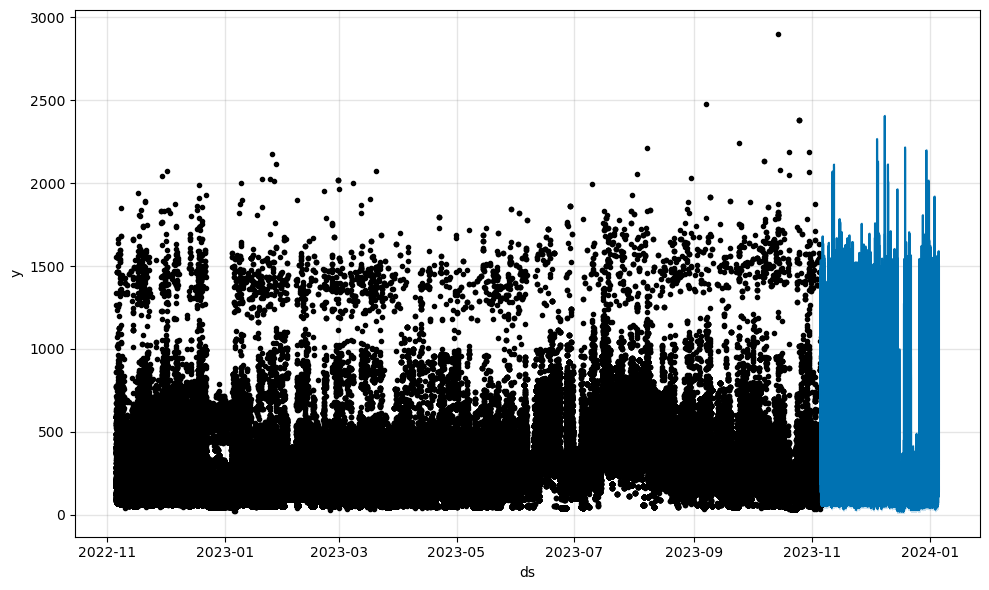

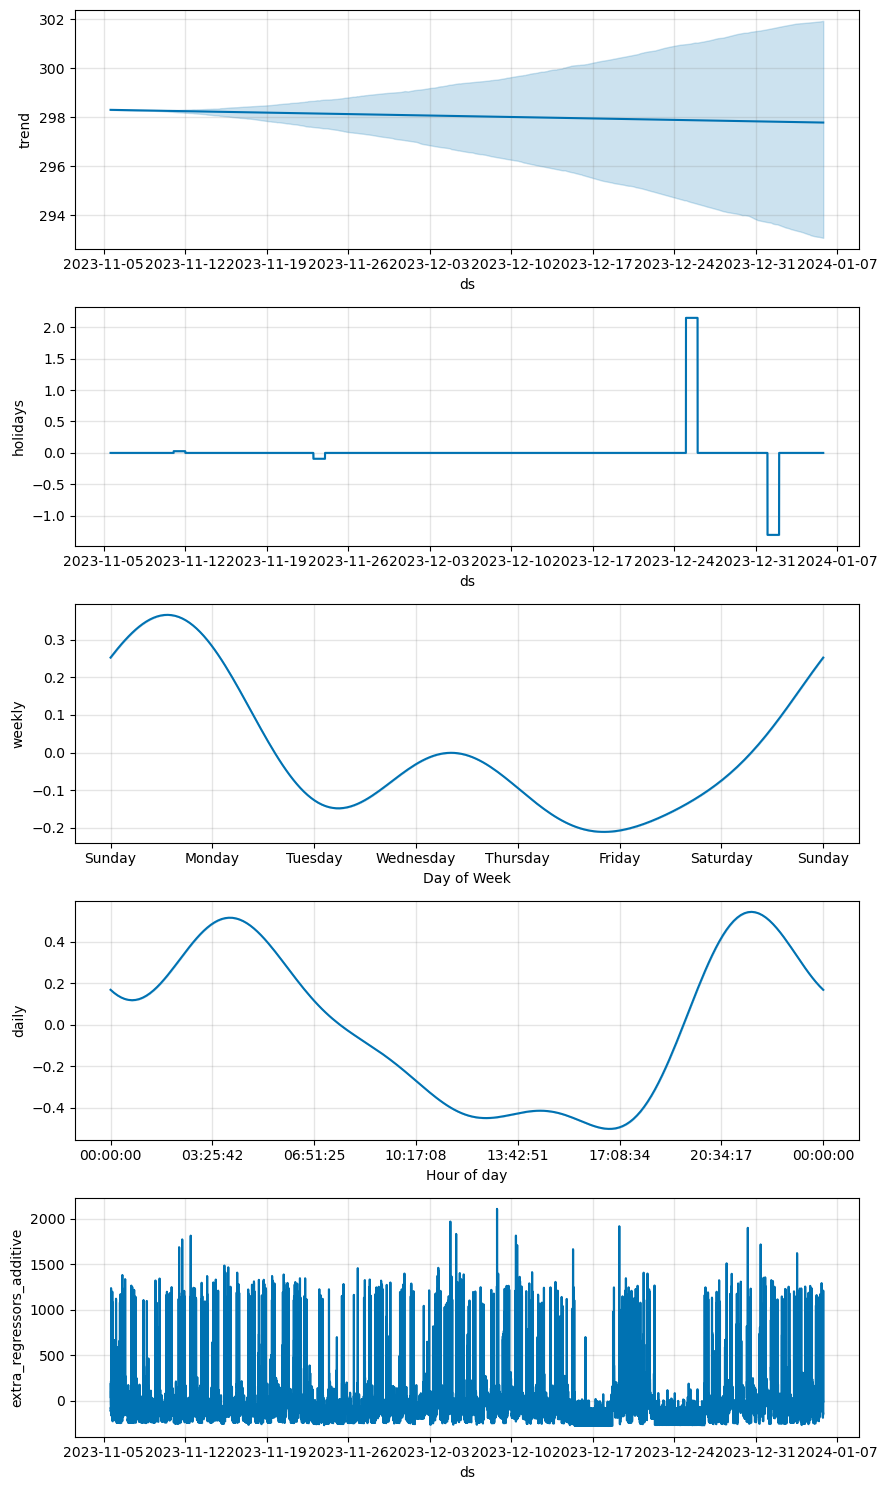

In [10]:
# Visualize the forecast
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

# Access the predicted power consumption values
predicted_power = forecast['yhat']

In [11]:
score_r2 = metrics.r2_score(test['y'], forecast['yhat'])
mae = metrics.mean_absolute_error(test['y'], forecast['yhat'])
mape = metrics.mean_absolute_percentage_error(test['y'], forecast['yhat'])
mse = metrics.mean_squared_error(test['y'], forecast['yhat'])
rmse = metrics.root_mean_squared_error(test['y'], forecast['yhat'])

print(f'R^2_score : {score_r2}')
print(f'MAE : {mae}')
print(f'MAPE : {mape}')
print(f'MSE : {mse}')
print(f'RMSE : {rmse}')

R^2_score : 0.9979372541939818
MAE : 5.115825939055159
MAPE : 0.04935478735981892
MSE : 64.51241572918472
RMSE : 8.031962134446646


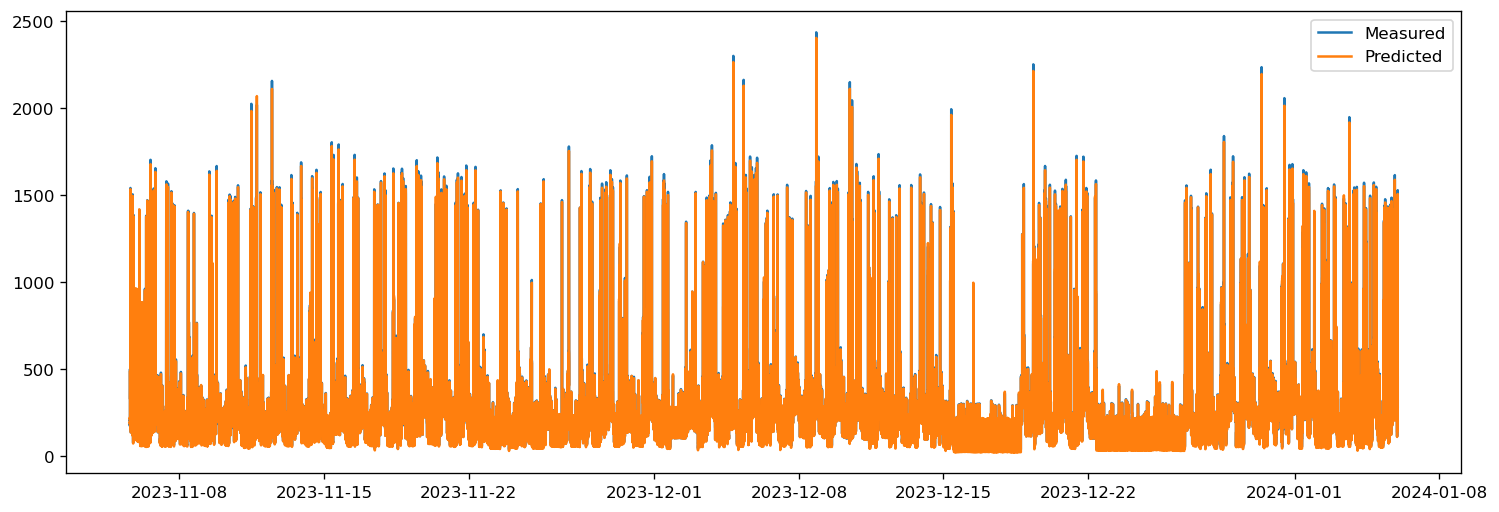

In [12]:
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':120})

plt.plot(test['ds'].to_list(), test['y'].to_list(), label='Measured')
plt.plot(test['ds'].to_list(), forecast['yhat'].to_list(), label='Predicted')
plt.legend()
plt.show()

In [13]:
# Create a Prophet model instance
model_final = Prophet()
model_final.add_country_holidays(country_name='US')

for c in df.drop(columns=['ds', 'y']).columns:
    model_final.add_regressor(c)

# Fit the model to the data
model_final.fit(df)

12:51:16 - cmdstanpy - INFO - Chain [1] start processing
12:54:12 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Save model to a JSON file
with open('model_prophet.json', 'w') as fout:
    fout.write(model_to_json(model_final))